['2024-05.json', '2024-06.json']


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[-0.14940978077571654, 0.0322935779816513, -0.24340000000000017, -0.5094547053649955, 0.0026442307692308015, 0.4814545454545455, 0.2748571428571427, 0.12749077490774927, 0.7281609195402298, 0.21942857142857145, -0.161448598130841, 0.24618055555555562, -0.47710937500000006, -0.32480392156862753, 0.6124675324675323, 0.31728395061728376, -0.34121779859484774, 0.6067484662576689, -0.3298181818181818, -0.005128205128205193, 0.4683977900552485, -0.515, -0.37747957992998843, -0.11818181818181811, -0.4638605442176871, 0.1316666666666668, -0.25652694610778437, -0.49677077818951826, 0.1456692913385827, 0.2664688427299704, -0.003204419889502768, -0.18138728323699418, 0.10000000000000003, -0.0017152658662091258, -0.48616833431430245, -0.07794676806083654, 0.1938461538461539, 0.26060191518467873, 0.5088888888888892, 0.009191919191919274, -0.025570776255707844, 0.21976047904191628, 0.009591836734693538, 0.8438016528925618, 0.10679487179487174]
count    45.000000
mean      0.030402
std       0.350073

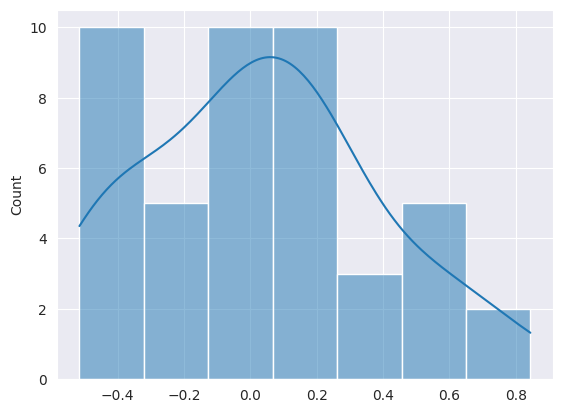

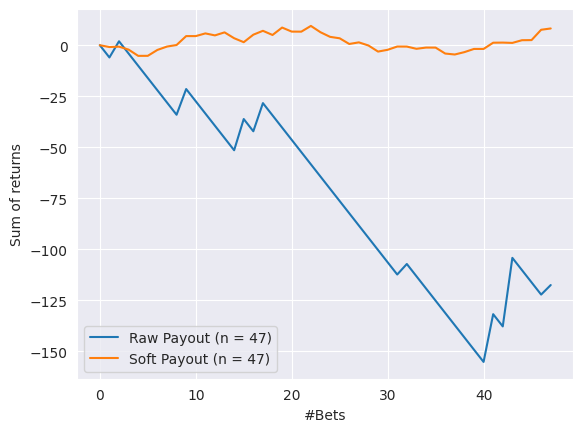

In [1]:
from Persistence.RaceCardPersistence import RaceDataPersistence
import pandas as pd
from Model.Betting.bet import Bet
from typing import List, Tuple
import os
from tqdm import tqdm
from Model.Betting.race_results_container import RaceResultsContainer
from matplotlib import pyplot as plt
import pickle
import seaborn as sns
from numpy import cumsum, mean

def get_win_prob_diffs(bet_odds_sp_pairs: List[Tuple[float, float]]) -> List[float]:
    win_prob_diffs = []
    for odds_pair in bet_odds_sp_pairs:
        bet_odds = odds_pair[0]
        sp = odds_pair[1]
        if sp > 0:
            bet_offer_win_prob = 1 / (bet_odds * (1 - 0.03))
            bet_sp_win_prob = 1 / sp
            
            win_prob_diffs.append((bet_sp_win_prob / bet_offer_win_prob) - 1)
            
    return win_prob_diffs

def plot_test_bets_return(payouts: List[float], axis, label: str) -> None:
    date_values = list(range(len(payouts)))
    cum_payout_values = cumsum(payouts)
    label = f"{label} (n = {len(test_bets)})"
    sns.lineplot(ax=axis, x=date_values, y=cum_payout_values, label=label)

TEST_BETS_PATH = "../data/bets_log"
test_bets = []

for file_name in os.listdir(TEST_BETS_PATH):
    if os.path.isfile(f"{TEST_BETS_PATH}/{file_name}"):
        with open(f"{TEST_BETS_PATH}/{file_name}", "rb") as f:
            test_bets += pickle.load(f)
    
race_cards_loader = RaceDataPersistence("race_cards_release")
race_results_container = RaceResultsContainer()

test_sample_file_names = race_cards_loader.race_data_file_names[-2:]

print(test_sample_file_names)

race_cards = {}

for race_card_file_name in tqdm(test_sample_file_names):
    race_cards = race_cards_loader.load_race_card_files_non_writable([race_card_file_name])
    race_results_container.add_results_from_race_cards(race_cards)
        
for bet in test_bets:
    horse_sp = 0
    for race_card in race_cards.values():
        # print(type(race_card.race_id))
        # print(type(race_card_id_bet))
        if race_card.datetime == bet.bet_offer.race_datetime:
            for horse in race_card.horses:
                if horse.number == bet.bet_offer.horse_number:
                    bet.bet_offer.live_result.starting_odds = horse.win_sp
                    bet.bet_offer.is_success = horse.has_won
                    bet.set_stakes(6.0)
     
clvs = [bet.bet_offer.live_result.clv for bet in test_bets if bet.bet_offer.live_result.clv != 0]
print(clvs)

print(pd.Series(clvs).describe())

sns.histplot(data=clvs, kde=True)

fig, axes = plt.subplots(1, 1)

axes.set(xlabel="#Bets", ylabel="Sum of returns")

payouts = [0.0] + [bet.bet_offer.live_result.profit for bet in test_bets]
plot_test_bets_return(payouts, axis=axes, label="Raw Payout")

soft_payouts = [0.0] + [bet.bet_offer.live_result.clv * 6.0 for bet in test_bets]
plot_test_bets_return(soft_payouts, axis=axes, label="Soft Payout")

In [3]:
test_bets = sorted(test_bets, key=lambda bet: bet.bet_offer.race_datetime)

for bet in test_bets:
    print(f"{bet.bet_offer.race_datetime}: {bet.bet_offer.horse_number}/{bet.bet_offer.live_result.offer_odds}")

2024-06-22 15:10:00: 1/1.86
2024-06-22 15:30:00: 1/5.5
2024-06-22 16:20:00: 10/2.92
2024-06-22 16:45:00: 5/6.0
2024-06-22 16:45:00: 6/9.0
2024-06-22 16:45:00: 10/12.5
2024-06-22 17:25:00: 2/24.0
2024-06-22 17:25:00: 5/19.0
2024-06-22 19:15:00: 13/4.9
2024-06-22 20:45:00: 1/4.4
2024-06-23 15:10:00: 8/8.4
2024-06-23 15:48:00: 4/4.6
2024-06-23 16:18:00: 5/3.15
2024-06-23 17:00:00: 1/4.4
2024-06-23 17:00:00: 2/3.7
2024-06-23 17:30:00: 7/3.7
2024-06-23 18:00:00: 10/3.45
2024-06-23 18:48:00: 1/3.1
2024-06-23 18:48:00: 2/4.8
2024-06-24 19:25:00: 6/3.85
2024-06-24 19:25:00: 8/2.56
2024-06-24 19:35:00: 6/9.8
2024-06-24 21:40:00: 1/3.0
2024-06-25 15:00:00: 4/3.9
2024-06-25 16:00:00: 4/11.5
2024-06-25 16:30:00: 11/4.3
2024-06-25 17:17:00: 6/5.2
2024-06-25 18:30:00: 2/2.32
2024-06-26 15:23:00: 7/5.5
2024-06-26 15:35:00: 1/3.55
2024-06-26 15:45:00: 7/20.0
2024-06-26 15:45:00: 3/2.74
2024-06-26 16:05:00: 4/6.4
2024-06-26 16:53:00: 1/6.0
2024-06-26 16:53:00: 3/3.25
2024-06-26 17:15:00: 5/3.9
2024-06-

/tmp/ipykernel_7888/1754105558.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(n_horses)


<AxesSubplot:ylabel='Density'>

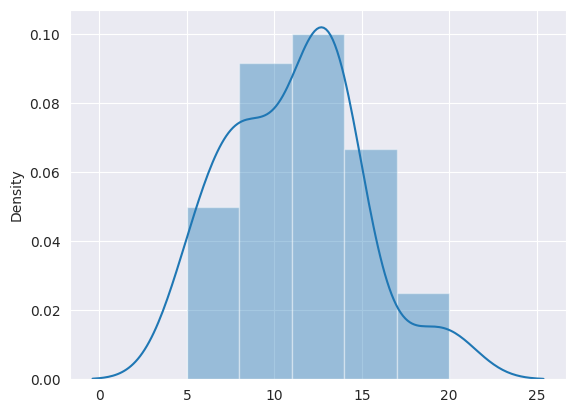

In [ ]:
from typing import List, Tuple
import seaborn as sns
import pandas as pd

bet_odds_sp_pairs = [
    (7.6, 5.99), (3.75, 3.09), (6, 4.92), (4.7, 5.31), (6.8, 12.04), (8.8, 6.01), (4.7, 1.9), (14, 16), (11.5, 15.35),
    (6.4, 5.73), (9.2, 4), (6.2, 4.07), (3.7, 4.92), (9.6, 8.47), (4.2, 3.97), (15.5, 15), (6.2, 11.5), (4.32, 3.52), (3.6, 5.27),
    (8.2, 8.23), (15.5, 12.03), (4.94, 9.51)
]
win_prob_diffs = get_win_prob_diffs(bet_odds_sp_pairs)

sp_win_probs = [1 / pair[1] for pair in bet_odds_sp_pairs]
print(f"Expected #wins: {sum(sp_win_probs)}")

print(pd.Series(win_prob_diffs).describe())
sns.histplot(data=win_prob_diffs, kde=True)

In [1]:
file_path = "../data/bets_log/2024-06-22 10:08:26.775461"

import pickle

# Step 2: Open the file in binary read mode
with open(file_path, 'rb') as file:
    # Step 3: Use pickle.load() to deserialize the object
    my_object = pickle.load(file)

# Now you can use `my_object` in your code
len(my_object)

10

In [ ]:
from typing import List, Tuple
import seaborn as sns
import pandas as pd

def get_win_prob_diffs(bet_odds_sp_pairs: List[Tuple[float, float]]) -> List[float]:
    win_prob_diffs = []
    for odds_pair in bet_odds_sp_pairs:
        bet_odds = odds_pair[0]
        sp = odds_pair[1]
        if sp > 0:
            bet_offer_win_prob = 1 / (bet_odds * (1 - 0.025))
            bet_sp_win_prob = 1 / sp

            win_prob_diffs.append((bet_sp_win_prob / bet_offer_win_prob) - 1)

    return win_prob_diffs

bet_odds_sp_pairs = [
    (7.6, 5.99), (3.75, 3.09), (6, 4.92), (4.7, 5.31), (6.8, 12.04), (8.8, 6.01), (4.7, 1.9), (14, 16), (11.5, 15.35),
    (6.4, 5.73), (9.2, 4), (6.2, 4.07), (3.7, 4.92), (9.6, 8.47), (4.2, 3.97), (15.5, 15), (6.2, 11.5), (4.32, 3.52), (3.6, 5.27),
    (8.2, 8.23), (15.5, 12.03), (4.94, 9.51)
]
win_prob_diffs = get_win_prob_diffs(bet_odds_sp_pairs)

sp_win_probs = [1 / pair[1] for pair in bet_odds_sp_pairs]
print(f"Expected #wins: {sum(sp_win_probs)}")

print(pd.Series(win_prob_diffs).describe())
sns.histplot(data=win_prob_diffs, kde=True)

In [ ]:
from typing import List, Tuple
import seaborn as sns
import pandas as pd

def get_win_prob_diffs(bet_odds_sp_pairs: List[Tuple[float, float]]) -> List[float]:
    win_prob_diffs = []
    for odds_pair in bet_odds_sp_pairs:
        bet_odds = odds_pair[0]
        sp = odds_pair[1]
        if sp > 0:
            bet_offer_win_prob = 1 / (bet_odds * (1 - 0.025))
            bet_sp_win_prob = 1 / sp

            win_prob_diffs.append((bet_sp_win_prob / bet_offer_win_prob) - 1)

    return win_prob_diffs

bet_odds_sp_pairs = [
    (7.6, 5.99), (3.75, 3.09), (6, 4.92), (4.7, 5.31), (6.8, 12.04), (8.8, 6.01), (4.7, 1.9), (14, 16), (11.5, 15.35),
    (6.4, 5.73), (9.2, 4), (6.2, 4.07), (3.7, 4.92), (9.6, 8.47), (4.2, 3.97), (15.5, 15), (6.2, 11.5), (4.32, 3.52), (3.6, 5.27),
    (8.2, 8.23), (15.5, 12.03), (4.94, 9.51)
]
win_prob_diffs = get_win_prob_diffs(bet_odds_sp_pairs)

sp_win_probs = [1 / pair[1] for pair in bet_odds_sp_pairs]
print(f"Expected #wins: {sum(sp_win_probs)}")

print(pd.Series(win_prob_diffs).describe())
sns.histplot(data=win_prob_diffs, kde=True)

In [ ]:
from typing import List, Tuple
import seaborn as sns
import pandas as pd

def get_win_prob_diffs(bet_odds_sp_pairs: List[Tuple[float, float]]) -> List[float]:
    win_prob_diffs = []
    for odds_pair in bet_odds_sp_pairs:
        bet_odds = odds_pair[0]
        sp = odds_pair[1]
        if sp > 0:
            bet_offer_win_prob = 1 / (bet_odds * (1 - 0.025))
            bet_sp_win_prob = 1 / sp

            win_prob_diffs.append((bet_sp_win_prob / bet_offer_win_prob) - 1)

    return win_prob_diffs

bet_odds_sp_pairs = [
    (7.6, 5.99), (3.75, 3.09), (6, 4.92), (4.7, 5.31), (6.8, 12.04), (8.8, 6.01), (4.7, 1.9), (14, 16), (11.5, 15.35),
    (6.4, 5.73), (9.2, 4), (6.2, 4.07), (3.7, 4.92), (9.6, 8.47), (4.2, 3.97), (15.5, 15), (6.2, 11.5), (4.32, 3.52), (3.6, 5.27),
    (8.2, 8.23), (15.5, 12.03), (4.94, 9.51)
]
win_prob_diffs = get_win_prob_diffs(bet_odds_sp_pairs)

sp_win_probs = [1 / pair[1] for pair in bet_odds_sp_pairs]
print(f"Expected #wins: {sum(sp_win_probs)}")

print(pd.Series(win_prob_diffs).describe())
sns.histplot(data=win_prob_diffs, kde=True)

In [ ]:
from typing import List, Tuple
import seaborn as sns
import pandas as pd

def get_win_prob_diffs(bet_odds_sp_pairs: List[Tuple[float, float]]) -> List[float]:
    win_prob_diffs = []
    for odds_pair in bet_odds_sp_pairs:
        bet_odds = odds_pair[0]
        sp = odds_pair[1]
        if sp > 0:
            bet_offer_win_prob = 1 / (bet_odds * (1 - 0.025))
            bet_sp_win_prob = 1 / sp

            win_prob_diffs.append((bet_sp_win_prob / bet_offer_win_prob) - 1)

    return win_prob_diffs

bet_odds_sp_pairs = [
    (7.6, 5.99), (3.75, 3.09), (6, 4.92), (4.7, 5.31), (6.8, 12.04), (8.8, 6.01), (4.7, 1.9), (14, 16), (11.5, 15.35),
    (6.4, 5.73), (9.2, 4), (6.2, 4.07), (3.7, 4.92), (9.6, 8.47), (4.2, 3.97), (15.5, 15), (6.2, 11.5), (4.32, 3.52), (3.6, 5.27),
    (8.2, 8.23), (15.5, 12.03), (4.94, 9.51)
]
win_prob_diffs = get_win_prob_diffs(bet_odds_sp_pairs)

sp_win_probs = [1 / pair[1] for pair in bet_odds_sp_pairs]
print(f"Expected #wins: {sum(sp_win_probs)}")

print(pd.Series(win_prob_diffs).describe())
sns.histplot(data=win_prob_diffs, kde=True)

In [ ]:
from typing import List, Tuple
import seaborn as sns
import pandas as pd

def get_win_prob_diffs(bet_odds_sp_pairs: List[Tuple[float, float]]) -> List[float]:
    win_prob_diffs = []
    for odds_pair in bet_odds_sp_pairs:
        bet_odds = odds_pair[0]
        sp = odds_pair[1]
        if sp > 0:
            bet_offer_win_prob = 1 / (bet_odds * (1 - 0.025))
            bet_sp_win_prob = 1 / sp

            win_prob_diffs.append((bet_sp_win_prob / bet_offer_win_prob) - 1)

    return win_prob_diffs

bet_odds_sp_pairs = [
    (7.6, 5.99), (3.75, 3.09), (6, 4.92), (4.7, 5.31), (6.8, 12.04), (8.8, 6.01), (4.7, 1.9), (14, 16), (11.5, 15.35),
    (6.4, 5.73), (9.2, 4), (6.2, 4.07), (3.7, 4.92), (9.6, 8.47), (4.2, 3.97), (15.5, 15), (6.2, 11.5), (4.32, 3.52), (3.6, 5.27),
    (8.2, 8.23), (15.5, 12.03), (4.94, 9.51)
]
win_prob_diffs = get_win_prob_diffs(bet_odds_sp_pairs)

sp_win_probs = [1 / pair[1] for pair in bet_odds_sp_pairs]
print(f"Expected #wins: {sum(sp_win_probs)}")

print(pd.Series(win_prob_diffs).describe())
sns.histplot(data=win_prob_diffs, kde=True)

In [1]:
from typing import List, Tuple
import seaborn as sns
import pandas as pd

def get_win_prob_diffs(bet_odds_sp_pairs: List[Tuple[float, float]]) -> List[float]:
    win_prob_diffs = []
    for odds_pair in bet_odds_sp_pairs:
        bet_odds = odds_pair[0]
        sp = odds_pair[1]
        if sp > 0:
            bet_offer_win_prob = 1 / (bet_odds * (1 - 0.025))
            bet_sp_win_prob = 1 / sp

            win_prob_diffs.append((bet_sp_win_prob / bet_offer_win_prob) - 1)

    return win_prob_diffs

bet_odds_sp_pairs = [
    (7.6, 5.99), (3.75, 3.09), (6, 4.92), (4.7, 5.31), (6.8, 12.04), (8.8, 6.01), (4.7, 1.9), (14, 16), (11.5, 15.35),
    (6.4, 5.73), (9.2, 4), (6.2, 4.07), (3.7, 4.92), (9.6, 8.47), (4.2, 3.97), (15.5, 15), (6.2, 11.5), (4.32, 3.52), (3.6, 5.27),
    (8.2, 8.23), (15.5, 12.03), (4.94, 9.51)
]
win_prob_diffs = get_win_prob_diffs(bet_odds_sp_pairs)

sp_win_probs = [1 / pair[1] for pair in bet_odds_sp_pairs]
print(f"Expected #wins: {sum(sp_win_probs)}")

print(pd.Series(win_prob_diffs).describe())
sns.histplot(data=win_prob_diffs, kde=True)

In [10]:
import numpy as np

bets = test_bets_base
n_successful_bets = len([bet for bet in bets if bet.profit > 0])
n_bets = len([bet for bet in bets if bet.profit != 0])

print(n_successful_bets)
print(n_bets)
print(n_successful_bets / n_bets)
print(np.mean([bet.bet_offer.odds for bet in test_bets_base if bet.profit > 0]))

In [4]:
for bet in test_bets_base:
    print(bet)

In [14]:
from Model.Betting.bet import Bet
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import cumsum

sns.set(rc={'figure.figsize':(15,3.5)})

def plot_test_bets_return(axis, test_bets: List[Bet]) -> None:
    payout_values = [bet.payout for bet in test_bets]
    x = [i for i in range(len(payout_values))]
    cum_payout_values = cumsum(payout_values)
    sns.lineplot(ax=axis, x=x, y=cum_payout_values)

fig, axes = plt.subplots(1, 3)
fig.suptitle('Return progressions for different bet subsets')

axes[0].set_title("All bets")
plot_test_bets_return(axis=axes[0], test_bets=test_bets_base)

test_bets_low_odds = [bet for bet in test_bets_base if bet.bet_offer.odds < 20]
axes[1].set_title("Bets with low odds")
plot_test_bets_return(axis=axes[1], test_bets=test_bets_low_odds)

test_bets = [bet for bet in test_bets_base if bet.probability_estimate > 0.25]
axes[2].set_title("Bets with high win prediction")
plot_test_bets_return(axis=axes[2], test_bets=test_bets)